# The House Price Prediction
## Team 4: Vicky van der Wagt, Halee Staggs, Bethany Wang

## 1. Introduction

The aim of this project was to build a regression to model house prices in King's County, Washington. The dataset utilized to develop the model contained 21,613 observations of houses that were sold between 2014 and 2015. The provided dataset first had to be organized and cleaned accordingly, as there many missing and duplicate values. Some missing variables could be derived from known values, while others were imputed in the manner we felt most reasonable. Exploratory data analysis was then performed to help determine important features, and data was cleaned further and additional features were transformed before fine-tuning the final model. 

## 2. Data Importing and Cleaning

* Import dataset and describe characteristics such as dimensions, data types, file types, and import methods used
* Clean, wrangle, and handle missing data
* Transform data appropriately using techniques such as aggregation, normalization, and feature construction
* Reduce redundant data and perform need-based discretization

In [1]:
#import packages and functions
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
from scipy.stats import spearmanr
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from numpy import mean
from numpy import absolute
from sklearn import preprocessing
from datetime import datetime

In [2]:
# To ignore the warning message
warnings.filterwarnings('ignore')

### Import data

In [3]:
dataset = pd.read_csv(r'house_sales.csv')
dataset.shape

(21613, 21)

### Check data characteristics

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       20479 non-null  float64
 4   bathrooms      20545 non-null  float64
 5   sqft_living    20503 non-null  float64
 6   sqft_lot       20569 non-null  float64
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [5]:
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Check missing data

In [6]:
dataset.isnull().sum()

id                  0
date                0
price               0
bedrooms         1134
bathrooms        1068
sqft_living      1110
sqft_lot         1044
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

We detect missing data in four columns: bedrooms, bathrooms, sqft_living, sqft_lot. Here are the strategies to handle the missing data:
* Fill the missing values in sqft_living: sqft_living = sqft_above +sqft_basement
* Check and remove outliers from sqft_living column: remove values greater than 7000
* Check distribution of sqft_living and divide it into different groups by size range: 0-999, 1000-1999, ...
* Fill sqft_lot with the mean of the the corresponding size range group
* Fill bedrooms with the median of the the corresponding size range group
* Fill bathrooms with the median of the the corresponding size range group

### Remove Outliers and Handle Missing Data

#### * Fill the missing values in sqft_living: sqft_living = sqft_above +sqft_basement

In [7]:
sqft_above_col = dataset['sqft_above']
sqft_basement_col = dataset['sqft_basement']
dataset['sqft_living'].fillna(sqft_above_col + sqft_basement_col, inplace = True)

#### * Remove outliers from sqft_living column: use 7000 as the upperlimit accoriding to the scatter plot

<AxesSubplot: xlabel='sqft_living', ylabel='price'>

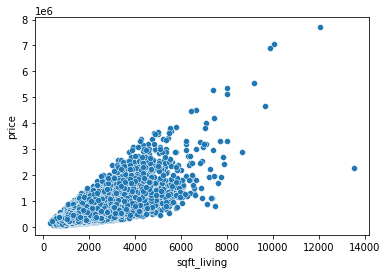

In [8]:
# Use scatter plot to check relationship of sqft_living and price
sns.scatterplot(data=dataset, x="sqft_living", y="price")

<AxesSubplot: title={'center': 'Square Footage Boxplot'}, xlabel='Sqft Living', ylabel='Counts'>

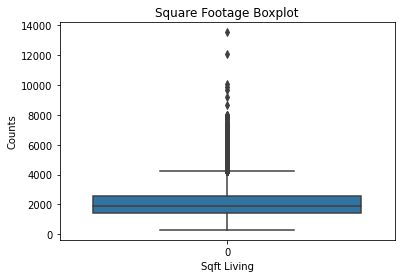

In [9]:
# use box plot to check distribution on sqft_living
plt.figure()
plt.title('Square Footage Boxplot')
plt.xlabel('Sqft Living')
plt.ylabel('Counts')
sns.boxplot(data = dataset['sqft_living'])

In [10]:
# Calculate IQR
q1 = dataset['sqft_living'].quantile(.25)
q3 = dataset['sqft_living'].quantile(.75)
iqr = q3 - q1
upperlimit = q3 + (1.5 * iqr)
upperlimit_count = len(dataset[dataset.sqft_living > upperlimit])
print(f"Upper limit by 1.5IQR = {upperlimit}, count = {upperlimit_count}")

Upper limit by 1.5IQR = 4234.5, count = 572


We use 7000 as the upperlimit to define outliers instead of using Q3+ (1.5IQR) as the upper limit eliminates, because 1.5IQR eliminates too many observations

In [134]:
upperlimit1 = 7000
dropped_count = len(dataset[dataset.sqft_living > upperlimit1])
dropped_percent = dropped_count / len(dataset)
print(f"{dropped_count} rows ({round(100 * dropped_percent, 3)} percent of data) have been dropped.")

dataset = dataset[dataset['sqft_living'] < upperlimit1]

dataset['sqft_sqrt'] = np.sqrt(dataset['sqft_living'])
dataset.shape

0 rows (0.0 percent of data) have been dropped.


(18984, 31)

<AxesSubplot: xlabel='sqft_living', ylabel='price'>

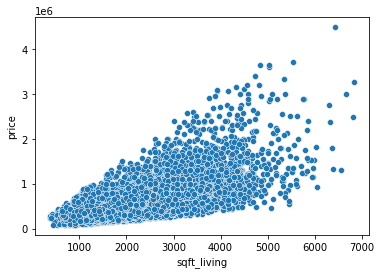

In [135]:
# Recheck sqft_living relationship with price
sns.scatterplot(data=dataset, x="sqft_living", y="price")

#### * Check sqft_lot distribution

<AxesSubplot: xlabel='sqft_lot', ylabel='price'>

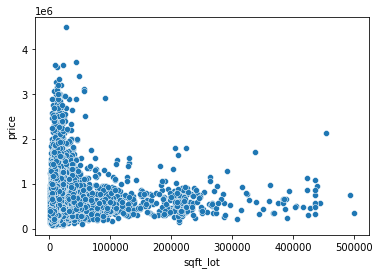

In [136]:
sns.scatterplot(data=dataset, x="sqft_lot", y="price")

#### * Remove outliers from sqft_lot column: use 500,000 as the upperlimit accoriding to the scatter plot, because Q3 + (1.5IQR) as an upper limit eliminates too many observations

In [14]:
#removed outliers with large sqft_lots
q1 = dataset['sqft_lot'].quantile(.25)
q3 = dataset['sqft_lot'].quantile(.75)
iqr = q3 - q1
upperlimit = q3 + (1.5*iqr)
upperlimit_count = len(dataset[dataset.sqft_lot > upperlimit])
print(f"Upper limit by 1.5IQR = {upperlimit}, count = {upperlimit_count}")

Upper limit by 1.5IQR = 19098.125, count = 2310


In [15]:
# dataset = dataset[dataset['sqft_living']<upperlimit]
upperlimit_set = 500000
upperlimit_set_count = len(dataset[dataset.sqft_lot > upperlimit_set])
print(f"Upper limit_set={upperlimit_set}, count = {upperlimit_set_count}")
dropped_count = len(dataset[dataset.sqft_lot > upperlimit_set])
dropped_percent = dropped_count / len(dataset)
print(f"{dropped_count} rows ({round(100 * dropped_percent, 3)} percent of data) have been dropped.")

dataset.drop(dataset[dataset.sqft_lot > upperlimit_set].index, inplace=True)


Upper limit_set=500000, count = 20
20 rows (0.093 percent of data) have been dropped.


<AxesSubplot: xlabel='sqft_lot', ylabel='price'>

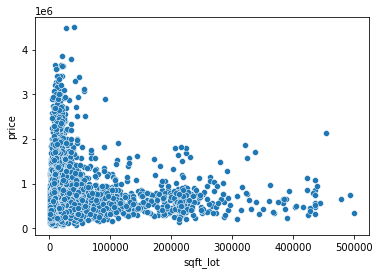

In [16]:
sns.scatterplot(data=dataset, x="sqft_lot", y="price")

#### * Remove outliers from bedrooms  columns

<AxesSubplot: title={'center': 'Boxplots'}, xlabel='Bedrooms', ylabel='Counts'>

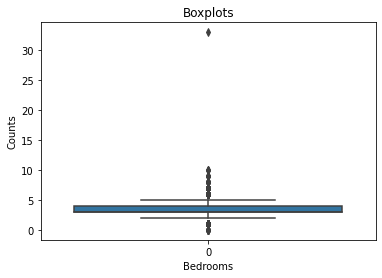

In [17]:
# Use boxplot to check outliers
plt.figure()
plt.title('Boxplots')
plt.xlabel('Bedrooms')
plt.ylabel('Counts')
sns.boxplot(data = dataset['bedrooms'])

From the box plot, any house with more than 6 bedrooms or 0 bedrooms can be counted as an outlier

In [18]:
# Check outliers' count
bedroom_drop_count = len(dataset[(dataset['bedrooms'] > 6) | (dataset['bedrooms'] == 0)])
data_count = len(dataset)
bedroom_drop_count_percent = round(100 * bedroom_drop_count/data_count, 2)

print(f"bedroom_drop_count= {bedroom_drop_count},  Percent={bedroom_drop_count_percent}%")

bedroom_drop_count= 64,  Percent=0.3%


In [19]:
# Drop outliers
dataset = dataset[(dataset['bedrooms'] <= 6) & (dataset['bedrooms'] > 0)]

#### * Remove outliers from bathrooms column

<AxesSubplot: title={'center': 'Boxplots'}, xlabel='Bathrooms', ylabel='Counts'>

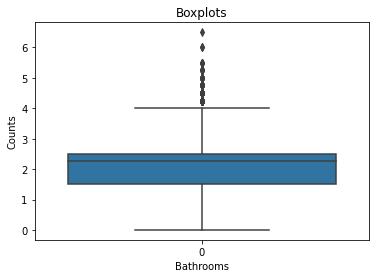

In [20]:
plt.figure()
plt.title('Boxplots')
plt.xlabel('Bathrooms')
plt.ylabel('Counts')
sns.boxplot(data = dataset['bathrooms'])

From the box plot, any house with more than 4 bathrooms or less than 0.75 bathrooms can be counted as an outlier

In [21]:
# Check outlier counts
bathroom_drop_count = len(dataset[(dataset['bathrooms'] >4) | (dataset['bathrooms'] < .75)])
bathroom_drop_count_percent = round(100 * bathroom_drop_count/data_count, 2)
print(f"bathroom_drop_count= {bathroom_drop_count},  Percent= {bathroom_drop_count_percent}%")


bathroom_drop_count= 216,  Percent= 1.0%


In [22]:
#Drop outliers
dataset = dataset[ (dataset['bathrooms'] <= 4) & (dataset['bathrooms'] >= .75) ]

dataset.shape

(19150, 22)

#### * Add a column  indicating the sqft_living range: 0 (0-999), 1000 (1000-1999), 2000(2000-2999) ... 6000(6000-6999)

In [23]:
dataset['sqft_living_range'] = (dataset['sqft_living']//1000) * 1000


####  * Impute missing data in bathrooms, bedrooms, sqft_lot with the mean/median by sqft_living_range


In [24]:
# Get unique range list
ranges = dataset['sqft_living_range'].unique()
imputed_dfs = []

for size_range in ranges:
    range_df = dataset[dataset['sqft_living_range'] == size_range]
    range_df['bathrooms'].fillna(range_df['bathrooms'].median(), inplace = True)
    range_df['bedrooms'].fillna(range_df['bedrooms'].median(), inplace = True)
    range_df['sqft_lot'].fillna(range_df['sqft_lot'].mean(), inplace = True)
      
    imputed_dfs.append(range_df)

#Combine all the region subset back into a new dataframe
dataset = pd.concat(imputed_dfs, axis=0)
dataset.isnull().sum()                                                  

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                 0
condition            0
grade                0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated         0
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
sqft_sqrt            0
sqft_living_range    0
dtype: int64

#### * Drop duplicate id

In [25]:
#sort data by id and date, and then keep the most recent entry of each duplicate id
dataset.sort_values(by=['id', 'date'], inplace=True)
dataset = dataset.drop_duplicates(subset=['id'], keep='last')
dataset.shape


(19005, 23)

* Drop redundant data columns: 

In [26]:
dataset.drop(['sqft_above', 'sqft_basement'], axis=1, inplace = True)

### Feature Construction

#### * Add columns for year sold, month sold, and season

In [27]:
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y/%m/%d')

dataset['yr_sold'] = pd.DatetimeIndex(dataset['date']).year
dataset['month_sold'] = pd.DatetimeIndex(dataset['date']).month


dataset['month_sold'] = dataset['month_sold'].astype(str)
look_up = {'1': 'Winter', '2': 'Winter', '3': 'Spring', '4': 'Spring', '5': 'Spring', 
           '6': 'Summer', '7': 'Summer', '8': 'Summer', '9': 'Fall', '10': 'Fall', '11': 'Fall', '12': 'Winter'}

dataset['season'] = dataset['month_sold'].apply(lambda x: look_up[x])
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_sqrt,sqft_living_range,yr_sold,month_sold,season
2497,1000102,2015-04-22,300000.0,6.0,3.00,2400.0,9373.0,2.0,0,0,...,98002,47.3262,-122.214,2060,7316,48.989795,2000.0,2015,4,Spring
6735,1200019,2014-05-08,647500.0,4.0,1.75,2060.0,26036.0,1.0,0,0,...,98166,47.4444,-122.351,2590,21891,45.387223,2000.0,2014,5,Spring
8411,1200021,2014-08-11,400000.0,3.0,1.00,1460.0,43000.0,1.0,0,0,...,98166,47.4434,-122.347,2250,20023,38.209946,1000.0,2014,8,Summer
8809,2800031,2015-04-01,235000.0,3.0,1.00,1430.0,7599.0,1.5,0,0,...,98168,47.4783,-122.265,1290,10320,37.815341,1000.0,2015,4,Spring
18521,3600072,2015-03-30,680000.0,4.0,2.75,2220.0,5310.0,1.0,0,0,...,98144,47.5801,-122.294,1540,4200,47.116876,2000.0,2015,3,Spring


#### * Add column to change year renovated to binary variable

In [28]:
#update dataset to Yes/No for renovated
dataset["renovate"] = pd.cut(dataset["yr_renovated"],2,labels = ['0','1'])
dataset["renovate"] = pd.to_numeric(dataset['renovate'])

#### * Add new column house_age = yr_sold - yr_built

In [29]:
t1 = dataset['yr_sold']
t2 = dataset['yr_built']
house_age = t1 - t2
dataset['house_age'] = house_age
dataset[['yr_sold', 'yr_built', 'house_age']].head()

,yr_sold,yr_built,house_age
2497,2015,1991,24
6735,2014,1947,67
8411,2014,1952,62
8809,2015,1930,85
18521,2015,1951,64


## 3. Exploratory Data Analysis and Visualization

* Identify categorical, ordinal, and numerical variables within the data
* Provide measures of centrality and distribution with visualizations
* Diagnose for correlations between variables and determine independent and dependent variables
* Perform exploratory analysis in combination with visualization techniques to discover patterns and features of interest

### Classify features

#### * Classify variables as categorical, ordinal, continues and discrete variables within the prepared dataset

In [30]:
# Identify categorical, ordinal, continues and discrete variables within the prepared data
cont_vars = ['price', 'sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'house_age']
discrete_vars = ['bedrooms', 'bathrooms', 'floors', 'yr_sold', 'month_sold']
ordinal_vars = ['condition', 'grade']
cat_vars = ['waterfront', 'view', 'zipcode', 'loc_cat', 'season']

### Statistical Analysis

#### * Get statistics on the continous numerical variables, house_age is discrete, but can be used as continuous type

In [31]:
cont_subset = dataset[cont_vars]

In [32]:
# Find the statistics for the numerical variables
round(cont_subset.describe(), 2)

,price,sqft_living,sqft_lot,sqft_living15,sqft_lot15,house_age
count,19005.00,19005.00,19005.00,19005.00,19005.00,19005.00
mean,525928.58,2042.93,14104.74,1971.30,12372.42,43.57
std,320477.52,843.70,30923.91,664.14,24913.79,29.36
min,78000.00,370.00,520.00,399.00,659.00,-1.00
25%,320600.00,1420.00,5109.00,1480.00,5100.00,18.00
50%,450000.00,1900.00,7794.00,1830.00,7592.00,40.00
75%,635000.00,2514.00,10766.00,2340.00,10000.00,63.00
max,4489000.00,6840.00,499571.00,5790.00,438213.00,115.00


### Correlation Analysis

In [33]:
# Find correlation coefficients between variables
corr_check_cols = cont_vars + discrete_vars + ordinal_vars

corr_check_subset = dataset[corr_check_cols]
round(corr_check_subset.corr(), 2)

,price,sqft_living,sqft_lot,sqft_living15,sqft_lot15,house_age,bedrooms,bathrooms,floors,yr_sold,condition,grade
price,1.00,0.67,0.09,0.59,0.07,-0.04,0.30,0.48,0.25,0.01,0.04,0.66
sqft_living,0.67,1.00,0.18,0.76,0.17,-0.33,0.59,0.73,0.35,-0.03,-0.06,0.75
sqft_lot,0.09,0.18,1.00,0.17,0.77,-0.06,0.04,0.08,-0.01,-0.00,-0.02,0.12
sqft_living15,0.59,0.76,0.17,1.00,0.19,-0.32,0.40,0.56,0.28,-0.02,-0.09,0.70
sqft_lot15,0.07,0.17,0.77,0.19,1.00,-0.07,0.03,0.07,-0.02,-0.00,-0.00,0.11
house_age,-0.04,-0.33,-0.06,-0.32,-0.07,1.00,-0.17,-0.53,-0.49,0.02,0.36,-0.45
bedrooms,0.30,0.59,0.04,0.40,0.03,-0.17,1.00,0.51,0.17,-0.01,0.03,0.36
bathrooms,0.48,0.73,0.08,0.56,0.07,-0.53,0.51,1.00,0.51,-0.03,-0.13,0.65
floors,0.25,0.35,-0.01,0.28,-0.02,-0.49,0.17,0.51,1.00,-0.03,-0.26,0.46
yr_sold,0.01,-0.03,-0.00,-0.02,-0.00,0.02,-0.01,-0.03,-0.03,1.00,-0.05,-0.03


<AxesSubplot: title={'center': 'Heat Map of Correlation Coefficients'}>

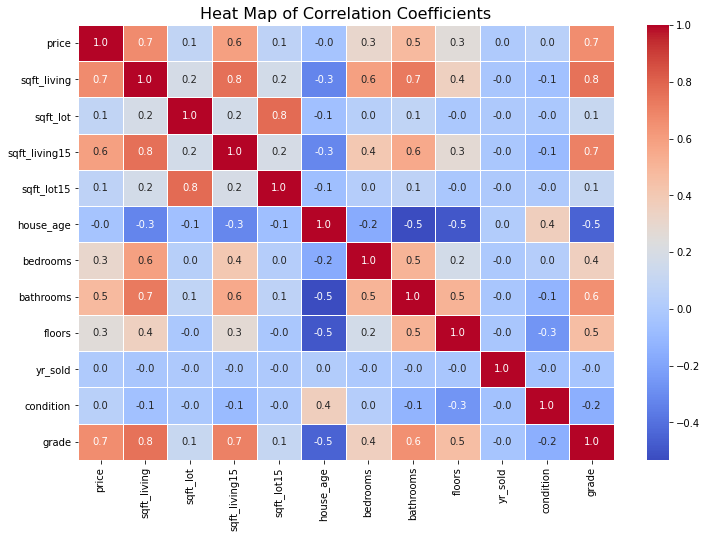

In [34]:
# Heatmap for correlations from original data
plt.figure(figsize=(12, 8))
plt.title("Heat Map of Correlation Coefficients", fontsize=16)
sns.heatmap(corr_check_subset.corr(), cmap = 'coolwarm', fmt = '.1f', linewidths = 1, annot = True)

From the heatmap, we see:
* Almost no correlation between dependent variable 'price' and independent variables: sqft_lot, house_age, condition, yr_sold, sft_lot15, therefore these variables will not be selected for modeling
* There are strong correlation between sqft_living and sqft_living15, between sqft_lot and sqft_lot15, therefore, we conclude that sqft_living15 and sqft_lot15 are redundant and should not be used in modeling

* There are strong correlation between dependent variable 'price' and independent variables: sqft_living, bathrooms, and grade, therefore these variables will be kept for modeling
* There are weak correlation between dependent variable 'price' and independent variables: bedrooms and floors. These variables will be kept for modeling

### Scatter Plots for Numerical Variables vs. Price

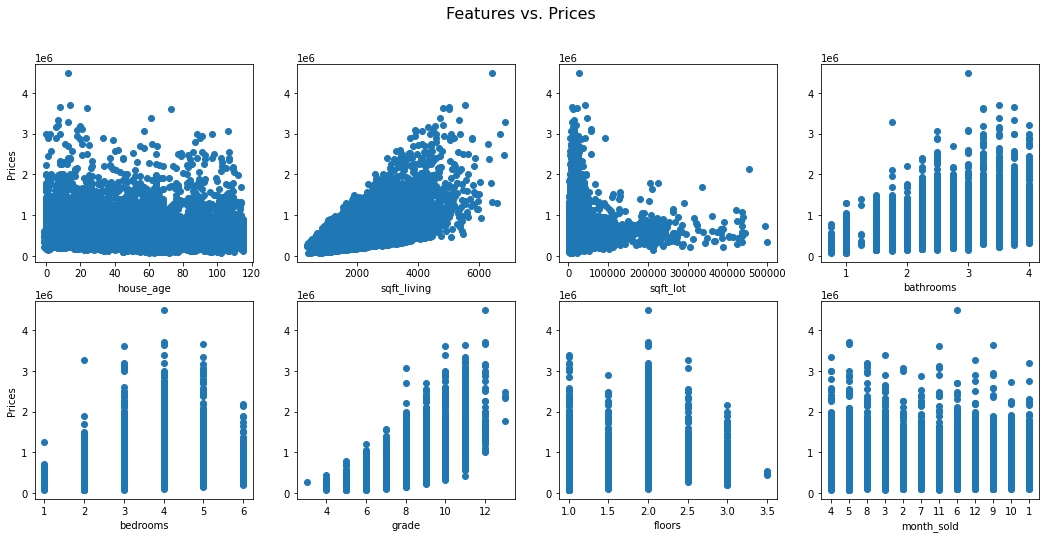

In [35]:
scatter_cols = ['house_age', 'sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade', 'floors', 'month_sold']
pair_cols = ['sqft_living', 'sqft_lot', 'grade', 'condition']

#Create scatter plots
fig,axes = plt.subplots(nrows=2,ncols=4,figsize=(18,8))
fig.suptitle("Features vs. Prices",fontsize=16)

#for n in range(len(scatter_cols)):
for n in (0,1,2,3,4,5,6,7):   
    i = 0 if n < 4 else 1  
    j = n % 4;
    axes[i][j].scatter(dataset[scatter_cols[n]], dataset['price'])
    axes[i][j].set_xlabel(scatter_cols[n])
    
axes[0][0].set_ylabel("Prices")
axes[1][0].set_ylabel("Prices")

plt.show()

The scatter plots shows that there is a linear relationship between dependent variable 'price' and independent variables 'sqft_living', 'bathrooms', and, 'grade'. There is no obvious linear relationship between price and the other variables listed above.

### Histogram Distribution for price and sqft_living

In [36]:
# Separate Prices into a new variable
prices = dataset['price']

<AxesSubplot: title={'center': 'Distribution of Prices'}, xlabel='price'>

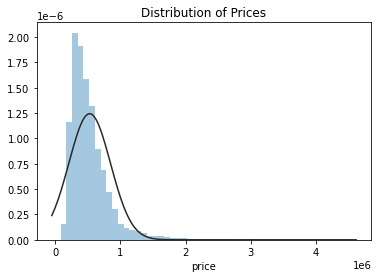

In [37]:
# Display Histogram for Prices
plt.figure(1)
plt.title('Distribution of Prices')
sns.distplot(prices, kde=False, fit=stats.norm)

Because the linear regression model requires that the dependent variable need to have a normal distribution. the distribution of the price is right skewed, therefore, we will try a log transformation on it.

#### Log transformation on price

<AxesSubplot: title={'center': 'Distribution of price_log'}, xlabel='price_log'>

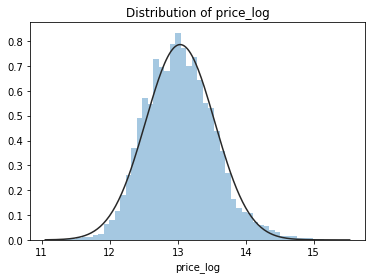

In [38]:
# Add a new column 'price_log'
dataset['price_log'] = np.log(dataset['price'])

# Display Histogram for Sqft_Living
plt.figure(2)
plt.title('Distribution of price_log')
sns.distplot(dataset['price_log'], kde=False, fit=stats.norm)

We see a normal distribution curve for price_log, therefore, price_log will be used for modeling.

### Bar Plots for Categorical and Discrete Variables

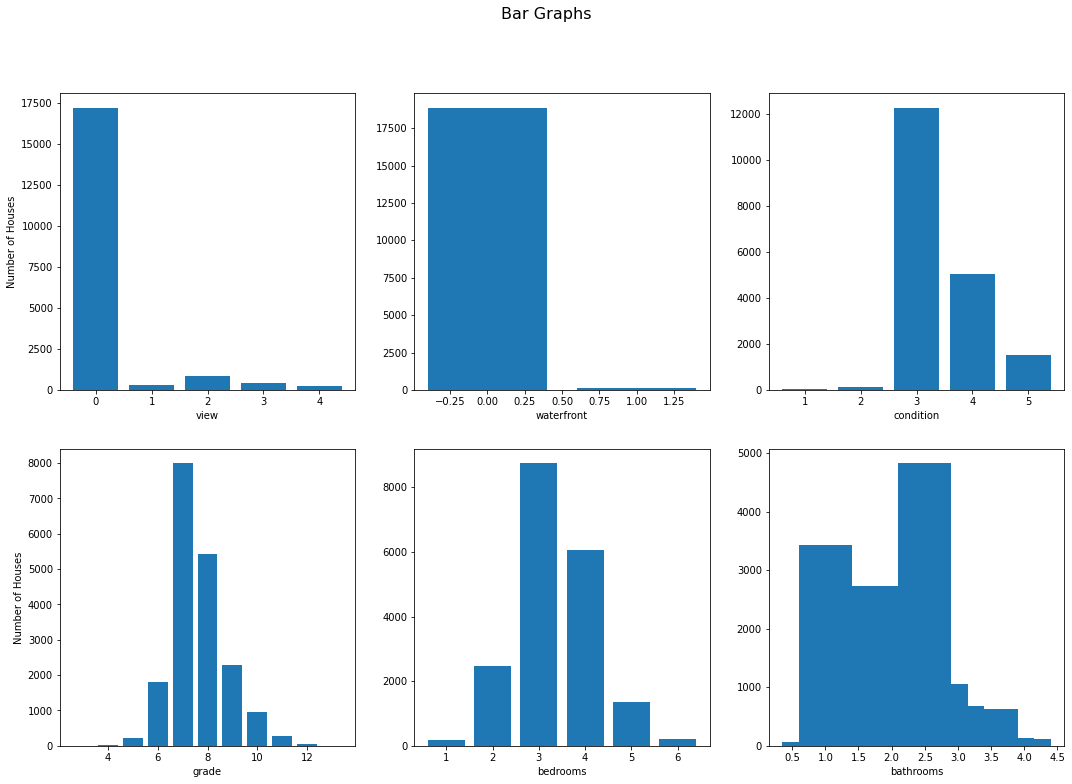

In [39]:
# Define column lists for plotting
bar_cols = ['view', 'waterfront', 'condition', 'grade', 'bedrooms', 'bathrooms']

# Create bar plots
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(18,12))
fig.suptitle("Bar Graphs",fontsize=16)

for n in (0, 1,2,3,4,5):
    i = 0 if n < 3 else 1  
    j = n % 3;
    values = dataset[bar_cols[n]].value_counts()
    pd.Series.sort_index(values, inplace=True)
    indexes = list(values.index)
    axes[i][j].bar(indexes, values)
    axes[i][j].set_xlabel(bar_cols[n])
    
axes[0][0].set_ylabel("Number of Houses")
axes[1][0].set_ylabel("Number of Houses")

plt.show()

From bar plot for view and water front, we see majority of the housed do not have view or by water front, therefore, these two features will not use considered in modeling

### Box Plot for Bedrooms, Bathrooms, Grade, and Condition

[(0.0, 1500000.0)]

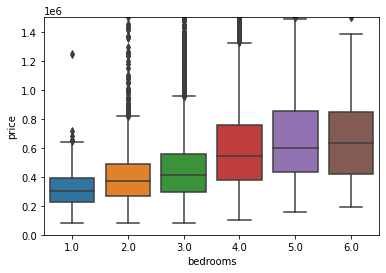

In [40]:
# Display box plot for 'bedrooms'
plot = sns.boxplot(x='bedrooms', y='price', data=dataset)
plot.set(ylim=(0, 1500000))

[(0.0, 1500000.0)]

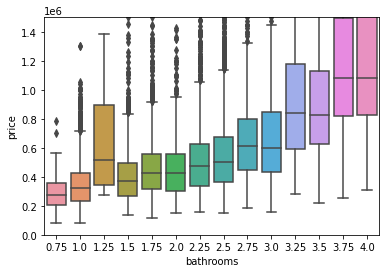

In [41]:
# Display box plot for 'bathrooms'
plot2 = sns.boxplot(x='bathrooms', y='price', data=dataset)
plot2.set(ylim=(0, 1500000))

[(0.0, 1500000.0)]

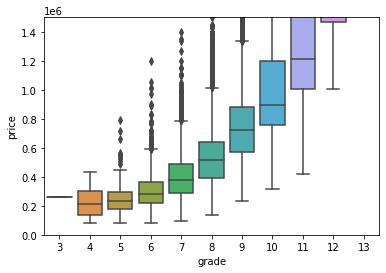

In [42]:
# Display box plot for 'grade'
plot3 = sns.boxplot(x='grade', y='price', data=dataset)
plot3.set(ylim=(0, 1500000))

[(0.0, 1500000.0)]

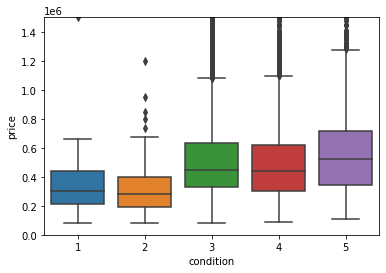

In [43]:
# Display box plot for 'condition'
plot4 = sns.boxplot(x='condition', y='price', data=dataset)
plot4.set(ylim=(0, 1500000))

[(0.0, 1500000.0)]

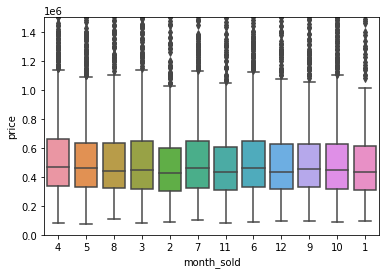

In [44]:
# Display box plot for 'month_sold'
plot5 = sns.boxplot(x='month_sold', y='price', data=dataset)
plot5.set(ylim=(0, 1500000))

[(0.0, 1500000.0)]

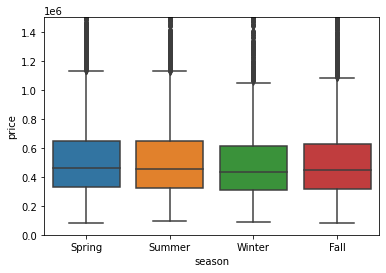

In [45]:
# Display box plot for 'month_sold'
plot5 = sns.boxplot(x='season', y='price', data=dataset)
plot5.set(ylim=(0, 1500000))

From the above box plots, we see that bathrooms, bedrooms, and grade affect the price with a certain degree of linear relationship, but condition does not.

### Joint Plot to show Distribution by Latiture and Longitude

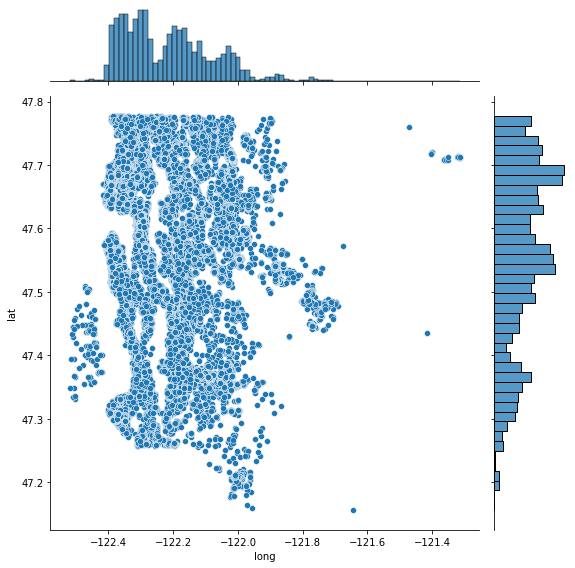

In [46]:
# Joint plot by long and lat
sns.jointplot(dataset['long'], dataset['lat'], size= 8)

### Remove outliers by location : long > -121.7

In [47]:
# Calculate outlier counts
upperlimit_set = -121.7
upperlimit_set_count = len(dataset[dataset.long > upperlimit_set])

dropped_count = len(dataset[dataset.long > upperlimit_set])
dropped_percent = dropped_count / len(dataset)
print(f"{dropped_count} rows ({round(100 * dropped_percent, 3)} percent of data) have been dropped.")


21 rows (0.11 percent of data) have been dropped.


In [48]:
# Remove outliers for long
dataset.drop(dataset[dataset.long > upperlimit_set].index, inplace=True)

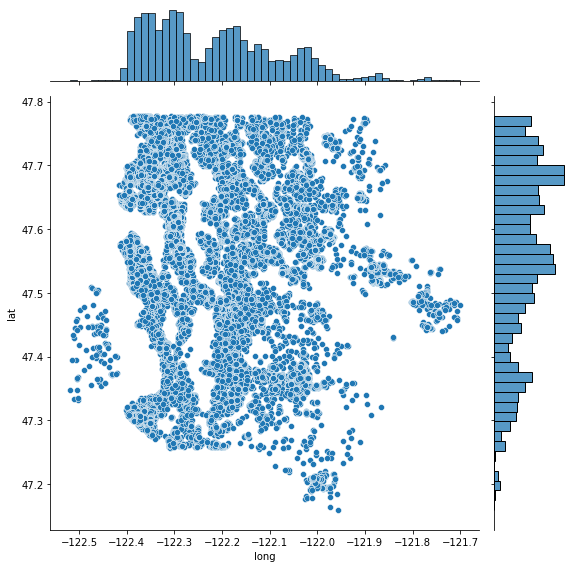

In [49]:
# Recreate joint plot
sns.jointplot(dataset['long'], dataset['lat'], size= 8)

## 4. Feature Engineering

### Feature Construction

#### * Generate Categories for lat, long, and latitude + longitude

[Text(0, 0, 'south-central'),
 Text(1, 0, 'central-west'),
 Text(2, 0, 'north-west'),
 Text(3, 0, 'central-central'),
 Text(4, 0, 'north-central'),
 Text(5, 0, 'south-west'),
 Text(6, 0, 'north-east'),
 Text(7, 0, 'central-east'),
 Text(8, 0, 'south-east')]

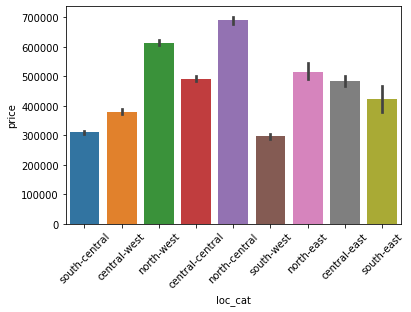

In [133]:
# Add column 'lat_cat' to represent the lattitude in three categories
dataset['lat_cat'] = pd.cut(dataset['lat'],3,labels = ['south', 'central', 'north'])
dataset.head()

# Add column 'long_cat' to represent the longitude in three categories
dataset['long_cat'] = pd.cut(dataset['long'],3,labels = ['west', 'central', 'east'])
dataset.head()

lat_cat = dataset['lat_cat']
long_cat = dataset['long_cat']

#aggregate the latitude and longitude together for a final location category
dataset['loc_cat'] = dataset[['lat_cat', 'long_cat']].agg('-'.join, axis=1)

location_category = dataset['loc_cat']
price = dataset['price']

#plot just to see
location_barplot = sns.barplot(x=location_category, y=price)
#makes it so the labels don't run into each other
location_barplot.set_xticklabels(location_barplot.get_xticklabels(), rotation = 45, horizontalalignment = 'center')

### Tests of Association (categorical)

In [52]:
#cut dataset into 6 bins for price_log
dataset['price_log_cat'] = pd.cut(dataset['price_log'], 6)
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_sold,month_sold,season,renovate,house_age,price_log,lat_cat,long_cat,loc_cat,price_log_cat
2497,1000102,2015-04-22,300000.0,6.0,3.00,2400.0,9373.0,2.0,0,0,...,2015,4,Spring,0,24,12.611538,south,central,south-central,"(11.94, 12.615]"
6735,1200019,2014-05-08,647500.0,4.0,1.75,2060.0,26036.0,1.0,0,0,...,2014,5,Spring,0,67,13.380874,central,west,central-west,"(13.291, 13.966]"
8411,1200021,2014-08-11,400000.0,3.0,1.00,1460.0,43000.0,1.0,0,0,...,2014,8,Summer,0,62,12.899220,central,west,central-west,"(12.615, 13.291]"
8809,2800031,2015-04-01,235000.0,3.0,1.00,1430.0,7599.0,1.5,0,0,...,2015,4,Spring,0,85,12.367341,central,west,central-west,"(11.94, 12.615]"
18521,3600072,2015-03-30,680000.0,4.0,2.75,2220.0,5310.0,1.0,0,0,...,2015,3,Spring,0,64,13.429848,north,west,north-west,"(13.291, 13.966]"


### Price and location (lat/long 3X3), lat only, long only.

In [53]:
chisq_freq_1_a = pd.crosstab(dataset['price_log_cat'], dataset['loc_cat'], margins=True, margins_name='Total')

#frequency table
chisq_freq_1_a

#run test to get stats and expected values
stats.chi2_contingency(chisq_freq_1_a)
#not valid, too many expected values below 5

(5869.530450475622,
 0.0,
 54,
 array([[3.21839444e+01, 4.71028234e+00, 2.66050358e+01, 3.68315424e+01,
         2.43573536e+00, 4.55446692e+01, 1.17846608e+01, 3.58196376e-01,
         9.54593342e+00, 1.70000000e+02],
        [7.28682364e+02, 1.06646334e+02, 6.02369311e+02, 8.33909450e+02,
         5.51479140e+01, 1.03118489e+03, 2.66818584e+02, 8.10998736e+00,
         2.16131163e+02, 3.84900000e+03],
        [1.77238875e+03, 2.59398019e+02, 1.46515497e+03, 2.02833470e+03,
         1.34137379e+02, 2.50817172e+03, 6.48988201e+02, 1.97260851e+01,
         5.25700169e+02, 9.36200000e+03],
        [9.10237674e+02, 1.33217868e+02, 7.52453013e+02, 1.04168268e+03,
         6.88883270e+01, 1.28811041e+03, 3.33297935e+02, 1.01306363e+01,
         2.69981458e+02, 4.80800000e+03],
        [1.36119153e+02, 1.99217236e+01, 1.12523651e+02, 1.55775759e+02,
         1.03017278e+01, 1.92627160e+02, 4.98421829e+01, 1.51495997e+00,
         4.03736831e+01, 7.19000000e+02],
        [1.43881163e+01, 2.10

In [54]:
chisq_freq_1_b = pd.crosstab(dataset['price_log_cat'], 
                           dataset['lat_cat'], 
                           margins=True, margins_name='Total')
chisq_freq_1_b

#run test
stats.chi2_contingency(chisq_freq_1_b)

#valid, stat sig, but df and x2 are far apart

(5159.264763859586,
 0.0,
 18,
 array([[2.16887906e+01, 6.34992625e+01, 8.48119469e+01, 1.70000000e+02],
        [4.91059735e+02, 1.43769801e+03, 1.92024226e+03, 3.84900000e+03],
        [1.19441445e+03, 3.49694174e+03, 4.67064381e+03, 9.36200000e+03],
        [6.13410029e+02, 1.79590855e+03, 2.39868142e+03, 4.80800000e+03],
        [9.17308260e+01, 2.68564528e+02, 3.58704646e+02, 7.19000000e+02],
        [9.69616519e+00, 2.83879056e+01, 3.79159292e+01, 7.60000000e+01],
        [2.42200000e+03, 7.09100000e+03, 9.47100000e+03, 1.89840000e+04]]))

In [55]:
chisq_freq_1_c = pd.crosstab(dataset['price_log_cat'], 
                           dataset['long_cat'], 
                           margins=True, margins_name='Total')
chisq_freq_1_c

#run test
stats.chi2_contingency(chisq_freq_1_c)

#not valid, one group expected value below 5

(250.063068878761,
 7.917682121764146e-43,
 18,
 array([[8.16956384e+01, 8.08001475e+01, 7.50421408e+00, 1.70000000e+02],
        [1.84968537e+03, 1.82941040e+03, 1.69904235e+02, 3.84900000e+03],
        [4.49902686e+03, 4.44971165e+03, 4.13261483e+02, 9.36200000e+03],
        [2.31054488e+03, 2.28521829e+03, 2.12236831e+02, 4.80800000e+03],
        [3.45524494e+02, 3.41737094e+02, 3.17384113e+01, 7.19000000e+02],
        [3.65227560e+01, 3.61224189e+01, 3.35482512e+00, 7.60000000e+01],
        [9.12300000e+03, 9.02300000e+03, 8.38000000e+02, 1.89840000e+04]]))

### Price and renovation  status.

In [56]:
#create frequency table for price bins and renovation status
chisq_freq_2 = pd.crosstab(dataset['price_log_cat'].astype('category'), 
                           dataset['renovate'], 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_2
stats.chi2_contingency(chisq_freq_2)

### valid relationship between renovation and price


(297.8306379762192,
 1.3401188719868606e-56,
 12,
 array([[1.62907712e+02, 7.09228824e+00, 1.70000000e+02],
        [3.68842225e+03, 1.60577750e+02, 3.84900000e+03],
        [8.97142351e+03, 3.90576485e+02, 9.36200000e+03],
        [4.60741340e+03, 2.00586599e+02, 4.80800000e+03],
        [6.89003793e+02, 2.99962073e+01, 7.19000000e+02],
        [7.28293300e+01, 3.17067004e+00, 7.60000000e+01],
        [1.81920000e+04, 7.92000000e+02, 1.89840000e+04]]))

### Price and year.

In [57]:
chisq_freq_3 = pd.crosstab(dataset['price_log_cat'].astype('category'), 
                           dataset['yr_sold'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_3
stats.chi2_contingency(chisq_freq_3)

#not valid, no difference

(2.727462103926928,
 0.9971813644006431,
 12,
 array([[  114.71238938,    55.28761062,   170.        ],
        [ 2597.22345133,  1251.77654867,  3849.        ],
        [ 6317.27876106,  3044.72123894,  9362.        ],
        [ 3244.33628319,  1563.66371681,  4808.        ],
        [  485.1659292 ,   233.8340708 ,   719.        ],
        [   51.28318584,    24.71681416,    76.        ],
        [12810.        ,  6174.        , 18984.        ]]))

## 5. Data Modeling and Analytics

* Determine the need for a supervised or unsupervised learning method and identify dependent and independent variables
* Train, test, and provide accuracy and evaluation metrics for model results


### The model for data requires a supervised learning method: multinomial linear regression.

* The outcome variable is price (price_log).
* Tested predictor variables are : sqft_scale, season, renovation, loc, lat, fl_scale, bd_scale, ba_scale, gr_scale.

## Creating Dummy Variables for Categorical Predictors

In [58]:
season_dum = pd.get_dummies(dataset['season'], prefix = 'sea')
season_dum

,sea_Fall,sea_Spring,sea_Summer,sea_Winter
2497,0,1,0,0
6735,0,1,0,0
8411,0,0,1,0
8809,0,1,0,0
18521,0,1,0,0
...,...,...,...,...
11654,1,0,0,0
16737,0,0,1,0
3260,0,1,0,0
7621,0,0,1,0


In [59]:
loc_dum = pd.get_dummies(dataset['loc_cat'], prefix = 'loc')
loc_dum

,loc_central-central,loc_central-east,loc_central-west,loc_north-central,loc_north-east,loc_north-west,loc_south-central,loc_south-east,loc_south-west
2497,0,0,0,0,0,0,1,0,0
6735,0,0,1,0,0,0,0,0,0
8411,0,0,1,0,0,0,0,0,0
8809,0,0,1,0,0,0,0,0,0
18521,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
11654,0,0,1,0,0,0,0,0,0
16737,0,0,1,0,0,0,0,0,0
3260,0,0,1,0,0,0,0,0,0
7621,0,0,1,0,0,0,0,0,0


In [60]:
lat_dum = pd.get_dummies(dataset['lat_cat'], prefix = 'lat')
lat_dum

,lat_south,lat_central,lat_north
2497,1,0,0
6735,0,1,0
8411,0,1,0
8809,0,1,0
18521,0,0,1
...,...,...,...
11654,0,1,0
16737,0,1,0
3260,0,1,0
7621,0,1,0


In [61]:
dataset_final = pd.concat([dataset, season_dum, lat_dum, loc_dum], axis = 1)
dataset_final.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat_north,loc_central-central,loc_central-east,loc_central-west,loc_north-central,loc_north-east,loc_north-west,loc_south-central,loc_south-east,loc_south-west
2497,1000102,2015-04-22,300000.0,6.0,3.00,2400.0,9373.0,2.0,0,0,...,0,0,0,0,0,0,0,1,0,0
6735,1200019,2014-05-08,647500.0,4.0,1.75,2060.0,26036.0,1.0,0,0,...,0,0,0,1,0,0,0,0,0,0
8411,1200021,2014-08-11,400000.0,3.0,1.00,1460.0,43000.0,1.0,0,0,...,0,0,0,1,0,0,0,0,0,0
8809,2800031,2015-04-01,235000.0,3.0,1.00,1430.0,7599.0,1.5,0,0,...,0,0,0,1,0,0,0,0,0,0
18521,3600072,2015-03-30,680000.0,4.0,2.75,2220.0,5310.0,1.0,0,0,...,1,0,0,0,0,0,1,0,0,0


## Scaling Numerical Data for Model Predictors

In [62]:
dataset_final['sqft_scale'] = preprocessing.scale(dataset_final['sqft_living'])
dataset_final['bd_scale'] = preprocessing.scale(dataset_final['bedrooms'])
dataset_final['ba_scale'] = preprocessing.scale(dataset_final['bathrooms'])
dataset_final['gr_scale'] = preprocessing.scale(dataset_final['grade'])
dataset_final['fl_scale'] = preprocessing.scale(dataset_final['floors'])

## Building A Model
#### Step 1: define X and y and put into linear regression function.
#### Step 2: check IVF values to check for multicolinearity issues (remove variables as necessary)
#### Step 3: train the model with 75% of the data
#### Step 4: confirm appropriate R2 value and see what variables are not statistically significant, remove if necessary and re-do model
#### Step 5: test the model with 25% of the data
#### Step 6: graph y-predictions against y-observed values
#### Step 7: evaluate model with kfolds for mean absolute error (lower is better)
#### Step 8: refine model and update predictor variables, continue until optimal model is found


# Model 1: All Variables
## Insights: Season is not significant so it will be removed.

In [63]:
#define predictors and outcome and fit to regression
X = dataset_final[['sqft_scale','fl_scale','bd_scale','ba_scale','gr_scale', 'lat_north','lat_central', 'renovate',
                   'sea_Winter','sea_Spring','sea_Summer']]
y = dataset_final[['price_log']]

model = LinearRegression().fit(X, y)
model.score(X,y)

0.716978867238222

In [64]:
#design matrix for model to check variance inflation factors 
y, X = dmatrices(
'price_log~sqft_scale+fl_scale+bd_scale+ba_scale+gr_scale+lat_north+lat_central+renovate+sea_Winter+sea_Spring+sea_Summer',
                 data=dataset_final, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,11.230425,Intercept
1,3.671455,sqft_scale
2,1.454610,fl_scale
3,1.651025,bd_scale
4,2.657867,ba_scale
5,2.737054,gr_scale
6,2.510363,lat_north
7,2.469693,lat_central
8,1.008118,renovate
9,1.439939,sea_Winter


In [65]:
#define test and train variables and proportions
X_train, X_test, y_train, \
y_test = train_test_split(X, y, test_size = 0.25, random_state = 222)

In [66]:
#verify test and train proportions
train_shape = X_train.shape[0]
test_shape = X_test.shape[0]
train_percent = train_shape/(train_shape + test_shape)
test_percent = test_shape/(train_shape + test_shape)
print('Train Size:', train_percent) 
print('Test Size:', test_percent)

Train Size: 0.75
Test Size: 0.25


In [67]:
#send training predictor values as constant
price_model = sm.add_constant(X_train)

In [68]:
#run ordinary least squares regression model with training data
price_model_results = OLS(y_train, X_train).fit()
price_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     3226.
Date:                Sun, 11 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:22:40   Log-Likelihood:                -1609.7
No. Observations:               14238   AIC:                             3243.
Df Residuals:                   14226   BIC:                             3334.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.6051      0.008   1655.157      0.000      12.590      12.620
sqft_scale      0.2120      0.004     48.750      0.000       0.204       0.221
fl_scale       -0.0114      0.003     -4.139      0.000      -0.017      -0.006
bd_scale       -0.0159      0.003     -5.482      0.000      -0.022      -0.010
ba_scale        0.0103      0.004      2.796      0.005       0.003       0.018
gr_scale        0.1600      0.004     42.738      0.000       0.153       0.167
lat_north       0.6107      0.007     84.984      0.000       0.597       0.625
lat_central     0.2923      0.007     39.696      0.000       0.278       0.307
renovate        0.1778      0.011     15.628      0.000       0.156       0.200
sea_Winter     -0.0068      0.007     -0.935      0.350      -0.021       0.007
sea_Spring      0.0406      0.006      6.473      0.000       0.028       0.053
sea_Summer      0.0034      0.006      0.538      0.590      -0.009       0.016
==============================================================================
Omnibus:                      427.512   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              632.319
Skew:                           0.309   Prob(JB):                    4.94e-138
Kurtosis:                       3.827   Cond. No.                         9.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
#create linear regression with training data observations
#create vector of predicted Y values with test set
price_mod = LinearRegression()
price_mod.fit(X_train, y_train)
y_pred = price_mod.predict(X_test)

<AxesSubplot: title={'center': 'Model 1: Linear Relationship Between Y-observed and Y-Predicted'}, xlabel='Price_Log Observed', ylabel='Price_Log Predicted'>

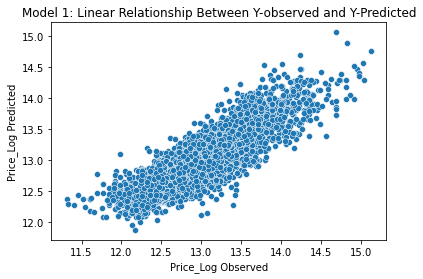

In [70]:
#plot observations vs. predictions, linearity confirmed
y_test_ar = pd.array(y_test['price_log'])
plot_df_x = pd.DataFrame(y_test_ar, columns = ['Price_Log'])
plot_df_y = pd.DataFrame(y_pred, columns = ['Price_Log Prediction'])
plot_df = pd.concat([plot_df_x, plot_df_y], axis = 1)
plot_df
plt.figure()
plt.title('Model 1: Linear Relationship Between Y-observed and Y-Predicted')
plt.xlabel('Price_Log Observed')
plt.ylabel('Price_Log Predicted')
sns.scatterplot(plot_df['Price_Log'], plot_df['Price_Log Prediction'])

In [71]:
#evaluate model with mean absolute error
#0.2063 log
mean_absolute_error(y_test, y_pred)

0.2063336493505065

In [72]:
#evaluate model with kfolds
cv = KFold(n_splits=5, random_state=222, shuffle=True)
scores = cross_val_score(price_mod, X_train, y_train, 
                         scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)
# view mean absolute error
ma_scores = mean(absolute(scores))
ma_scores

#0.2103 log

0.21025966262824008

# Model 2
## Insights: Remove renovation due to low contribution to the variance. 

In [73]:
#define predictors and outcome 
X2 = dataset_final[['sqft_scale','fl_scale','bd_scale','ba_scale','gr_scale', 'lat_north','lat_central', 'renovate']]
y2 = dataset_final[['price_log']]
#put X and y into regression 
model2 = LinearRegression().fit(X2, y2)
model2.score(X2,y2)

0.7154580409200135

In [74]:
#design matrix to get variance inflation factors
y2, X2 = dmatrices('price_log~sqft_scale+fl_scale+bd_scale+ba_scale+gr_scale+lat_north+lat_central+renovate',
                 data=dataset_final, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif['variable'] = X2.columns
vif

,VIF,variable
0,7.910631,Intercept
1,3.671381,sqft_scale
2,1.454231,fl_scale
3,1.650815,bd_scale
4,2.657496,ba_scale
5,2.735990,gr_scale
6,2.507782,lat_north
7,2.467080,lat_central
8,1.007795,renovate


In [75]:
#create train and test variables and define proportion split
X2_train, X2_test, y2_train, \
y2_test = train_test_split(X2, y2, test_size = 0.25, random_state = 222)

In [76]:
#verify proportion split
train_shape = X2_train.shape[0]
test_shape = X2_test.shape[0]
train_percent = train_shape/(train_shape + test_shape)
test_percent = test_shape/(train_shape + test_shape)
print('Train Size:', train_percent) 
print('Test Size:', test_percent)

Train Size: 0.75
Test Size: 0.25


In [77]:
#define predictor observations as constant
price_model2 = sm.add_constant(X2_train)

In [78]:
#run ordinary least squares on training data
price_model2_results = OLS(y2_train, X2_train).fit()
price_model2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     4406.
Date:                Sun, 11 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:22:42   Log-Likelihood:                -1645.0
No. Observations:               14238   AIC:                             3308.
Df Residuals:                   14229   BIC:                             3376.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.6163      0.006   1974.206      0.000      12.604      12.629
sqft_scale      0.2114      0.004     48.507      0.000       0.203       0.220
fl_scale       -0.0116      0.003     -4.189      0.000      -0.017      -0.006
bd_scale       -0.0159      0.003     -5.449      0.000      -0.022      -0.010
ba_scale        0.0102      0.004      2.773      0.006       0.003       0.017
gr_scale        0.1605      0.004     42.781      0.000       0.153       0.168
lat_north       0.6116      0.007     84.960      0.000       0.598       0.626
lat_central     0.2939      0.007     39.832      0.000       0.279       0.308
renovate        0.1781      0.011     15.616      0.000       0.156       0.200
==============================================================================
Omnibus:                      437.810   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              639.562
Skew:                           0.318   Prob(JB):                    1.32e-139
Kurtosis:                       3.820   Cond. No.                         8.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
#create linear regression with training data and use observations to predict y values
price_mod2 = LinearRegression()
price_mod2.fit(X2_train, y2_train)
y2_pred = price_mod2.predict(X2_test)

<AxesSubplot: title={'center': 'Model 2: Linear Relationship Between Y-observed and Y-Predicted'}, xlabel='Price_Log Observed', ylabel='Price_Log Predicted'>

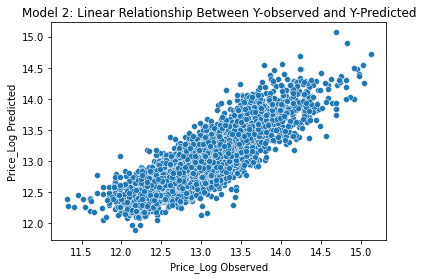

In [80]:
#plot observations vs. predictions, linearity confirmed
y2_test_ar = pd.array(y2_test['price_log'])
plot_df_x2 = pd.DataFrame(y2_test_ar, columns = ['Price_Log'])
plot_df_y2 = pd.DataFrame(y2_pred, columns = ['Price_Log Prediction'])
plot_df2 = pd.concat([plot_df_x2, plot_df_y2], axis = 1)
plot_df2
plt.figure()
plt.title('Model 2: Linear Relationship Between Y-observed and Y-Predicted')
plt.xlabel('Price_Log Observed')
plt.ylabel('Price_Log Predicted')
sns.scatterplot(plot_df2['Price_Log'], plot_df2['Price_Log Prediction'])

In [81]:
#evaluate model with MAE
# 0.2072 log
mean_absolute_error(y2_test, y2_pred)

0.20717055717075666

In [82]:
#evaluate model with kfolds
cv2 = KFold(n_splits=5, random_state=222, shuffle=True)
scores2 = cross_val_score(price_mod2, X2_train, y2_train, 
                         scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)
# view mean absolute error
ma_scores2 = mean(absolute(scores2))
ma_scores2

# 0.2107 log

0.21067591743226255

#  Model 3
## Insights: Remove floors and bedrooms due to low contribution to the variance. 

In [83]:
#define predictors and out variable and define linear regression
X3 = dataset_final[['sqft_scale','fl_scale','bd_scale','ba_scale','gr_scale', 'lat_north','lat_central']]
y3 = dataset_final[['price_log']]

model3 = LinearRegression().fit(X3, y3)
model3.score(X3,y3)

0.7104994898679715

In [84]:
#matrix for variance inflation factors 
y3, X3 = dmatrices('price_log~sqft_scale+fl_scale+bd_scale+ba_scale+gr_scale+lat_north+lat_central',
                 data=dataset_final, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
vif['variable'] = X3.columns
vif

,VIF,variable
0,7.896907,Intercept
1,3.659694,sqft_scale
2,1.454020,fl_scale
3,1.649341,bd_scale
4,2.655759,ba_scale
5,2.728417,gr_scale
6,2.503104,lat_north
7,2.466108,lat_central


In [85]:
#define test and train variables and split proportion
X3_train, X3_test, y3_train, \
y3_test = train_test_split(X3, y3, test_size = 0.25, random_state = 222)

In [86]:
#verify split proportion
train_shape = X3_train.shape[0]
test_shape = X3_test.shape[0]
train_percent = train_shape/(train_shape + test_shape)
test_percent = test_shape/(train_shape + test_shape)
print('Train Size:', train_percent) 
print('Test Size:', test_percent)

Train Size: 0.75
Test Size: 0.25


In [87]:
#define training predictors as constant
price_model3 = sm.add_constant(X3_train)

In [88]:
#run ordinary least squares 
price_model3_results = OLS(y3_train, X3_train).fit()
price_model3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     4917.
Date:                Sun, 11 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:22:43   Log-Likelihood:                -1766.0
No. Observations:               14238   AIC:                             3548.
Df Residuals:                   14230   BIC:                             3608.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.6207      0.006   1960.164      0.000      12.608      12.633
sqft_scale      0.2148      0.004     48.920      0.000       0.206       0.223
fl_scale       -0.0121      0.003     -4.327      0.000      -0.018      -0.007
bd_scale       -0.0172      0.003     -5.858      0.000      -0.023      -0.011
ba_scale        0.0116      0.004      3.122      0.002       0.004       0.019
gr_scale        0.1579      0.004     41.758      0.000       0.150       0.165
lat_north       0.6161      0.007     84.929      0.000       0.602       0.630
lat_central     0.2961      0.007     39.804      0.000       0.282       0.311
==============================================================================
Omnibus:                      478.125   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              683.797
Skew:                           0.347   Prob(JB):                    3.28e-149
Kurtosis:                       3.820   Cond. No.                         8.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
#define linear regression test and train data and use test set to predict y
price_mod3 = LinearRegression()
price_mod3.fit(X3_train, y3_train)
y3_pred = price_mod3.predict(X3_test)

<AxesSubplot: title={'center': 'Model 3: Linear Relationship Between Y-observed and Y-Predicted'}, xlabel='Price_Log Observed', ylabel='Price_Log Predicted'>

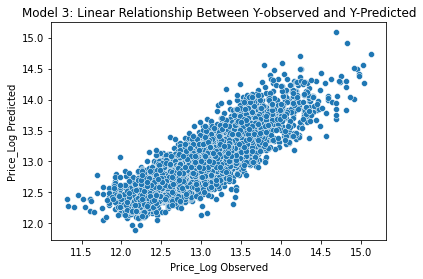

In [90]:
#plot observations vs. predictions, linearity confirmed
y3_test_ar = pd.array(y3_test['price_log'])
plot_df_x3 = pd.DataFrame(y3_test_ar, columns = ['Price_Log'])
plot_df_y3 = pd.DataFrame(y3_pred, columns = ['Price_Log Prediction'])
plot_df3 = pd.concat([plot_df_x3, plot_df_y3], axis = 1)
plot_df3
plt.figure()
plt.title('Model 3: Linear Relationship Between Y-observed and Y-Predicted')
plt.xlabel('Price_Log Observed')
plt.ylabel('Price_Log Predicted')
sns.scatterplot(plot_df3['Price_Log'], plot_df3['Price_Log Prediction'])

In [91]:
#evaluate model with MAE
# .2088 log
mean_absolute_error(y3_test, y3_pred)

0.20878664668705957

In [92]:
#evaluate model with kfolds
cv3 = KFold(n_splits=5, random_state=222, shuffle=True)
scores3 = cross_val_score(price_mod3, X3_train, y3_train, 
                         scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)
# view mean absolute error
ma_scores3 = mean(absolute(scores3))
ma_scores3

#0.2126

0.21261218103704027

# Model 4
## Insights: Remove bathrooms due to non-significance. 

In [93]:
#define predictors and outcome variable and put into regression
X4 = dataset_final[['sqft_scale','ba_scale','gr_scale', 'lat_north','lat_central']]
y4 = dataset_final[['price_log']]

model4 = LinearRegression().fit(X4, y4)
model4.score(X4,y4)

0.7093549519993944

In [94]:
#matrix for variance inflation factors
y4, X4 = dmatrices('price_log~sqft_scale+ba_scale+gr_scale+lat_north+lat_central',
                 data=dataset_final, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X4.values, i) for i in range(X4.shape[1])]
vif['variable'] = X4.columns
vif

,VIF,variable
0,7.887761,Intercept
1,2.971612,sqft_scale
2,2.237701,ba_scale
3,2.484870,gr_scale
4,2.499575,lat_north
5,2.463777,lat_central


In [95]:
#define test and train variables and split proportion
X4_train, X4_test, y4_train, \
y4_test = train_test_split(X4, y4, test_size = 0.25, random_state = 222)

In [96]:
#verify split proportion
train_shape = X4_train.shape[0]
test_shape = X4_test.shape[0]
train_percent = train_shape/(train_shape + test_shape)
test_percent = test_shape/(train_shape + test_shape)
print('Train Size:', train_percent) 
print('Test Size:', test_percent)

Train Size: 0.75
Test Size: 0.25


In [97]:
#add training set predictors as constant
price_model4 = sm.add_constant(X4_train)

In [98]:
#run ordinary least squares on training set
price_model4_results = OLS(y4_train, X4_train).fit()
price_model4_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     6851.
Date:                Sun, 11 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:22:43   Log-Likelihood:                -1790.9
No. Observations:               14238   AIC:                             3594.
Df Residuals:                   14232   BIC:                             3639.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.6200      0.006   1957.752      0.000      12.607      12.633
sqft_scale      0.2068      0.004     52.016      0.000       0.199       0.215
ba_scale        0.0023      0.003      0.682      0.495      -0.004       0.009
gr_scale        0.1580      0.004     43.675      0.000       0.151       0.165
lat_north       0.6166      0.007     84.903      0.000       0.602       0.631
lat_central     0.2969      0.007     39.862      0.000       0.282       0.311
==============================================================================
Omnibus:                      508.591   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              727.720
Skew:                           0.363   Prob(JB):                    9.50e-159
Kurtosis:                       3.837   Cond. No.                         7.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
#create regression with training data, then use test data to predict y values
price_mod4 = LinearRegression()
price_mod4.fit(X4_train, y4_train)
y4_pred = price_mod4.predict(X4_test)

<AxesSubplot: title={'center': 'Model 4: Linear Relationship Between Y-observed and Y-Predicted'}, xlabel='Price_Log Observed', ylabel='Price_Log Predicted'>

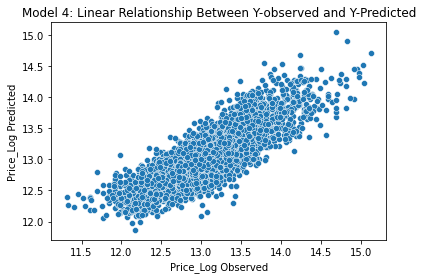

In [100]:
#plot observations vs. predictions, linearity confirmed
y4_test_ar = pd.array(y4_test['price_log'])
plot_df_x4 = pd.DataFrame(y4_test_ar, columns = ['Price_Log'])
plot_df_y4 = pd.DataFrame(y4_pred, columns = ['Price_Log Prediction'])
plot_df4 = pd.concat([plot_df_x4, plot_df_y4], axis = 1)
plot_df4
plt.figure()
plt.title('Model 4: Linear Relationship Between Y-observed and Y-Predicted')
plt.xlabel('Price_Log Observed')
plt.ylabel('Price_Log Predicted')
sns.scatterplot(plot_df4['Price_Log'], plot_df4['Price_Log Prediction'])

In [101]:
#evaluate model with MAE
mean_absolute_error(y4_test, y4_pred)
#0.2094

0.20939074730297474

In [102]:
#evaluate model with kfolds
cv4 = KFold(n_splits=5, random_state=222, shuffle=True)
scores4 = cross_val_score(price_mod4, X4_train, y4_train, 
                         scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

# view mean absolute error
ma_scores4 = mean(absolute(scores4))
ma_scores4
#0.213

0.21297722233712868

# Model 5: Removed all categorical variables
## Insights: Floors and bathrooms are still not significant. Low R2 value. Categorical location variable is important. 

In [103]:
#define predictors and outcome variable and test regression
X5 = dataset_final[['sqft_scale','fl_scale','bd_scale','ba_scale','gr_scale']]
y5 = dataset_final[['price_log']]

model5 = LinearRegression().fit(X5, y5)
model5.score(X5,y5)

0.5306189828071555

In [104]:
#matrix for variance inflation factors
y5, X5 = dmatrices('price_log~sqft_scale+fl_scale+bd_scale+ba_scale+gr_scale',
                 data=dataset_final, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X5.values, i) for i in range(X5.shape[1])]
vif['variable'] = X5.columns
vif

,VIF,variable
0,1.000000,Intercept
1,3.652406,sqft_scale
2,1.453469,fl_scale
3,1.647441,bd_scale
4,2.647669,ba_scale
5,2.669471,gr_scale


In [105]:
#define train and test variables and split proportion
X5_train, X5_test, y5_train, \
y5_test = train_test_split(X5, y5, test_size = 0.25, random_state = 222)

In [106]:
#verify proportion
train_shape = X5_train.shape[0]
test_shape = X5_test.shape[0]
train_percent = train_shape/(train_shape + test_shape)
test_percent = test_shape/(train_shape + test_shape)
print('Train Size:', train_percent) 
print('Test Size:', test_percent)

Train Size: 0.75
Test Size: 0.25


In [107]:
#set training predictor as constant
price_model5 = sm.add_constant(X5_train)

In [108]:
#run ordinary least squares on training set 
price_model5_results = OLS(y5_train, X5_train).fit()
price_model5_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     3179.
Date:                Sun, 11 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:22:44   Log-Likelihood:                -5178.6
No. Observations:               14238   AIC:                         1.037e+04
Df Residuals:                   14232   BIC:                         1.041e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0379      0.003   4467.841      0.000      13.032      13.044
sqft_scale     0.2100      0.006     37.673      0.000       0.199       0.221
fl_scale      -0.0070      0.004     -1.978      0.048      -0.014   -6.26e-05
bd_scale      -0.0224      0.004     -6.011      0.000      -0.030      -0.015
ba_scale      -0.0081      0.005     -1.719      0.086      -0.017       0.001
gr_scale       0.2045      0.005     43.026      0.000       0.195       0.214
==============================================================================
Omnibus:                       42.372   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.679
Skew:                           0.119   Prob(JB):                     8.90e-10
Kurtosis:                       2.883   Cond. No.                         4.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
#use training regression to predict y values from test set
price_mod5 = LinearRegression()
price_mod5.fit(X5_train, y5_train)
y5_pred = price_mod5.predict(X5_test)

<AxesSubplot: title={'center': 'Model 5: Linear Relationship Between Y-observed and Y-Predicted'}, xlabel='Price_Log Observed', ylabel='Price_Log Predicted'>

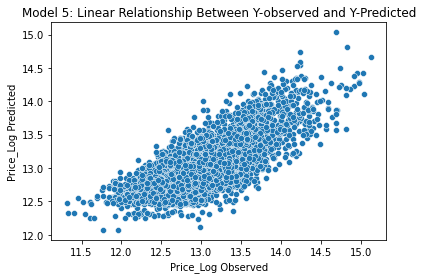

In [110]:
#plot observations vs. predictions, linearity confirmed
y5_test_ar = pd.array(y5_test['price_log'])
plot_df_x5 = pd.DataFrame(y5_test_ar, columns = ['Price_Log'])
plot_df_y5 = pd.DataFrame(y5_pred, columns = ['Price_Log Prediction'])
plot_df5 = pd.concat([plot_df_x5, plot_df_y5], axis = 1)
plot_df5
plt.figure()
plt.title('Model 5: Linear Relationship Between Y-observed and Y-Predicted')
plt.xlabel('Price_Log Observed')
plt.ylabel('Price_Log Predicted')
sns.scatterplot(plot_df5['Price_Log'], plot_df5['Price_Log Prediction'])

In [111]:
#evaluate model with MAE
mean_absolute_error(y5_test, y5_pred)
#0.2806

0.27991424323875896

In [112]:
#evaluate model with kfolds
cv5 = KFold(n_splits=5, random_state=222, shuffle=True)
scores5 = cross_val_score(price_mod5, X5_train, y5_train, 
                         scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

# view mean absolute error
ma_scores5 = mean(absolute(scores5))
ma_scores5
# 0.2809

0.2806466432884074

# Model 6: Square footage and lattitude location.
## Insights: R2 value may be overfit. 

In [113]:
#define predictors and outcome and put into regression
X6 = dataset_final[['sqft_scale','lat_north','lat_central']]
y6 = dataset_final[['price_log']]

model6 = LinearRegression().fit(X6, y6)
model6.score(X6,y6)

0.6670712111065631

In [114]:
#matrix for variance inflation factors
y6, x6 = dmatrices('price_log~sqft_scale+lat_north+lat_central',
                 data=dataset_final, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X6.values, i) for i in range(X6.shape[1])]
vif['variable'] = X6.columns
vif

,VIF,variable
0,1.003547,sqft_scale
1,1.002311,lat_north
2,1.001236,lat_central


In [115]:
#define train and test variables and split proportion
X6_train, X6_test, y6_train, \
y6_test = train_test_split(X6, y6, test_size = 0.25, random_state = 222)

In [116]:
#verify split proportion
train_shape = X6_train.shape[0]
test_shape = X6_test.shape[0]
train_percent = train_shape/(train_shape + test_shape)
test_percent = test_shape/(train_shape + test_shape)
print('Train Size:', train_percent) 
print('Test Size:', test_percent)

Train Size: 0.75
Test Size: 0.25


In [117]:
#add training constant
price_model6 = sm.add_constant(X6_train)

In [118]:
#run ordinary least squares
price_model6_results = OLS(y6_train, X6_train).fit()
price_model6_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.880
Model:                            OLS   Adj. R-squared (uncentered):              0.880
Method:                 Least Squares   F-statistic:                          3.484e+04
Date:                Sun, 11 Dec 2022   Prob (F-statistic):                        0.00
Time:                        17:22:44   Log-Likelihood:                         -41673.
No. Observations:               14238   AIC:                                  8.335e+04
Df Residuals:                   14235   BIC:                                  8.337e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_scale      0.1754      0.038      4.613      0.000       0.101       0.250
lat_north      13.2631      0.054    246.640      0.000      13.158      13.369
lat_central    12.8913      0.062    208.363      0.000      12.770      13.013
==============================================================================
Omnibus:                     5656.439   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16526.802
Skew:                           2.203   Prob(JB):                         0.00
Kurtosis:                       5.906   Cond. No.                         1.63
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
#use training regression to predict y values with test set
price_mod6 = LinearRegression()
price_mod6.fit(X6_train, y6_train)
y6_pred = price_mod6.predict(X6_test)

<AxesSubplot: title={'center': 'Model 6: Linear Relationship Between Y-observed and Y-Predicted'}, xlabel='Price_Log Observed', ylabel='Price_Log Predicted'>

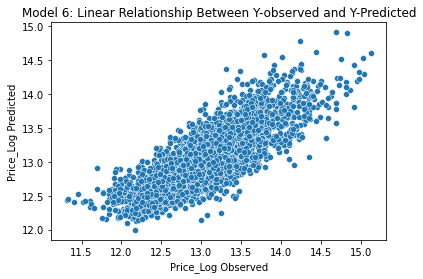

In [120]:
#plot observations vs. predictions, linearity confirmed
y6_test_ar = pd.array(y6_test['price_log'])
plot_df_x6 = pd.DataFrame(y6_test_ar, columns = ['Price_Log'])
plot_df_y6 = pd.DataFrame(y6_pred, columns = ['Price_Log Prediction'])
plot_df6 = pd.concat([plot_df_x6, plot_df_y6], axis = 1)
plot_df6
plt.figure()
plt.title('Model 6: Linear Relationship Between Y-observed and Y-Predicted')
plt.xlabel('Price_Log Observed')
plt.ylabel('Price_Log Predicted')
sns.scatterplot(plot_df6['Price_Log'], plot_df6['Price_Log Prediction'])

In [121]:
#evaluate model with MAE
mean_absolute_error(y6_test, y6_pred)
#0.225

0.2250181214542002

In [122]:
#evaluate model with kfolds
cv6 = KFold(n_splits=5, random_state=222, shuffle=True)
scores6 = cross_val_score(price_mod6, X6_train, y6_train, 
                         scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

# view mean absolute error
ma_scores6 = mean(absolute(scores6))
ma_scores6
# 0.2271

0.22707882114916716

# Final Model: Price predicted from square footage, grade, and lattitude location.

## *price_log* ~ 12.6202 + 0.2081*sqft_scale* + 0.1586*gr_scale* + 0.6164*lat_north* + 0.2969*lat_central* + *e*

In [123]:
#define predictors and outcome and set regression
Xf = dataset_final[['sqft_scale','gr_scale', 'lat_north','lat_central']]
yf = dataset_final[['price_log']]

modelf = LinearRegression().fit(Xf, yf)
modelf.score(Xf,yf)

0.7093540367543613

In [124]:
#matrix for variance inflation factors 
yf, Xf = dmatrices('price_log~sqft_scale+gr_scale+lat_north+lat_central',
                 data=dataset_final, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(Xf.values, i) for i in range(Xf.shape[1])]
vif['variable'] = Xf.columns
vif

,VIF,variable
0,7.870898,Intercept
1,2.306916,sqft_scale
2,2.351272,gr_scale
3,2.491560,lat_north
4,2.461022,lat_central


In [125]:
#define test and train variables and split proportion
Xf_train, Xf_test, yf_train, \
yf_test = train_test_split(Xf, yf, test_size = 0.25, random_state = 222)

In [126]:
#verify split proportion
train_shape = Xf_train.shape[0]
test_shape = Xf_test.shape[0]
train_percent = train_shape/(train_shape + test_shape)
test_percent = test_shape/(train_shape + test_shape)
print('Train Size:', train_percent) 
print('Test Size:', test_percent)

Train Size: 0.75
Test Size: 0.25


In [127]:
#add training constant
price_modelf = sm.add_constant(Xf_train)

In [128]:
#run ordinary least squares
price_modelf_results = OLS(yf_train, Xf_train).fit()
price_modelf_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     8564.
Date:                Sun, 11 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:22:44   Log-Likelihood:                -1791.1
No. Observations:               14238   AIC:                             3592.
Df Residuals:                   14233   BIC:                             3630.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.6202      0.006   1959.465      0.000      12.608      12.633
sqft_scale      0.2081      0.004     59.433      0.000       0.201       0.215
gr_scale        0.1586      0.004     45.034      0.000       0.152       0.165
lat_north       0.6164      0.007     84.991      0.000       0.602       0.631
lat_central     0.2968      0.007     39.859      0.000       0.282       0.311
==============================================================================
Omnibus:                      503.824   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              721.776
Skew:                           0.360   Prob(JB):                    1.85e-157
Kurtosis:                       3.836   Cond. No.                         6.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:
#use training regression to predict Y values from test set
price_modf = LinearRegression()
price_modf.fit(Xf_train, yf_train)
yf_pred = price_modf.predict(Xf_test)

<AxesSubplot: title={'center': 'Final Model: Linear Relationship Between Y-observed and Y-Predicted'}, xlabel='Price_Log Observed', ylabel='Price_Log Predicted'>

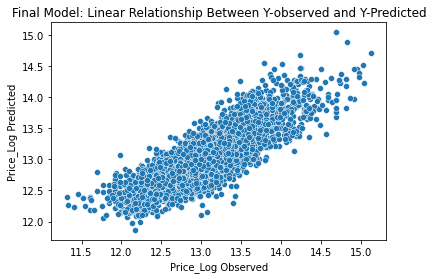

In [130]:
#plot observations vs. predictions, linearity confirmed
yf_test_ar = pd.array(yf_test['price_log'])
plot_df_xf = pd.DataFrame(yf_test_ar, columns = ['Price_Log'])
plot_df_yf = pd.DataFrame(yf_pred, columns = ['Price_Log Prediction'])
plot_dff = pd.concat([plot_df_xf, plot_df_yf], axis = 1)
plot_dff
plt.figure()
plt.title('Final Model: Linear Relationship Between Y-observed and Y-Predicted')
plt.xlabel('Price_Log Observed')
plt.ylabel('Price_Log Predicted')
sns.scatterplot(plot_dff['Price_Log'], plot_dff['Price_Log Prediction'])

In [131]:
#evaluate model with MAE
mean_absolute_error(yf_test, yf_pred)

# 0.2094

0.20937676356578383

In [132]:
#evaluate model with kfolds
cvf = KFold(n_splits=5, random_state=222, shuffle=True)
scoresf = cross_val_score(price_modf, Xf_train, yf_train, 
                         scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

# view mean absolute error
ma_scoresf = mean(absolute(scoresf))
ma_scoresf

#0.213

0.21298611398046888

## 6. Conclusion
The final proposed model is: *price_log* ~ 12.6202 + 0.2081*sqft_scale* + 0.1586*gr_scale* + 0.6164*lat_north* + 0.2969*lat_central* + *e* . The R2 for this model is .706, which means the predictors account for 70.6% of the variance in the observed data. The variance inflation factors for the predictors are almost equal to each other and all are less than 3, meaning that colineariry is not an issue for this model. All *p* values are less than .001 for the predictors. The mean absolute error is 0.213log, which means that the average residual between observed-y and predicted-y is 0.213log. 

When using this model, price must be log transformed, and square footage and grade must be scaled.

## References

#### AskPython. (2022). 2 easy ways to standardize data in python for machine learning. https://www.askpython.com/python/examples/standardize-data-in-python

#### Pankaj. (2022, August 3). Pandas drop duplicate rows - drop_duplicates() function. DigitalOcean. https://www.digitalocean.com/community/tutorials/pandas-drop-duplicate-rows-drop_duplicates-function 
 
#### Python Datetime. Programiz. (n.d.). https://www.programiz.com/python-programming/datetime 

#### SciPy Community. (2022). scipy.stats.contingency.chi2_contingency. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.chi2_contingency.html#scipy.stats.contingency.chi2_contingency

#### Shpaner, L. (2022). Python introductory iorkshop by University of San Diego (USD): Module 6 video lab session - introduction to machine learning. 

#### Tan, E. (2022, April 18). How to bin numerical data with Pandas. Medium. https://towardsdatascience.com/how-to-bin-numerical-data-with-pandas-fe5146c9dc55 


#### Zach. (2021). How to use dummy variables in regression analysis. https://www.statology.org/dummy-variables-regression/
